In [ ]:
from datetime import timedelta
import matplotlib.pyplot as plt
import time
from concurrent.futures import ThreadPoolExecutor

from pyfleascope.flea_scope import FleaScope, Waveform
from pyfleascope.trigger_config import AnalogTrigger, DigitalTrigger, BitState

In [ ]:
scope1 = FleaScope.connect('scope1', baud=115200)

In [ ]:
scope2 = FleaScope.connect('scope2', baud=115200)

In [4]:
scope2.set_waveform(Waveform.EKG, 1000)

In [ ]:
capture_time = timedelta(microseconds=120)

# Capture data from two FleaScopes simultaneously by trigger forwarding
# TRIGGER_OUT on scope2 is connected to Bit 0 on scope1 via a wire.
# scope1 is set to start capturing when Bit 0 goes high.

def capture_scope1():
    return scope1.probe1.read(
            capture_time,
            DigitalTrigger.start_capturing_when().bit0(BitState.HIGH).starts_matching(),
    )

def capture_scope2():
    time.sleep(1) # give scope1 time to prepare
    return scope2.probe1.read(
        capture_time,
        AnalogTrigger.start_capturing_when().auto(volts=2),
    )

with ThreadPoolExecutor(max_workers=3) as executor:
    f1 = executor.submit(capture_scope1)
    f2 = executor.submit(capture_scope2)
    df1 = f1.result()
    df2 = f2.result()

df1 = FleaScope.extract_bits(df1)
df1['bit_0'] = df1['bit_0'].apply(int)

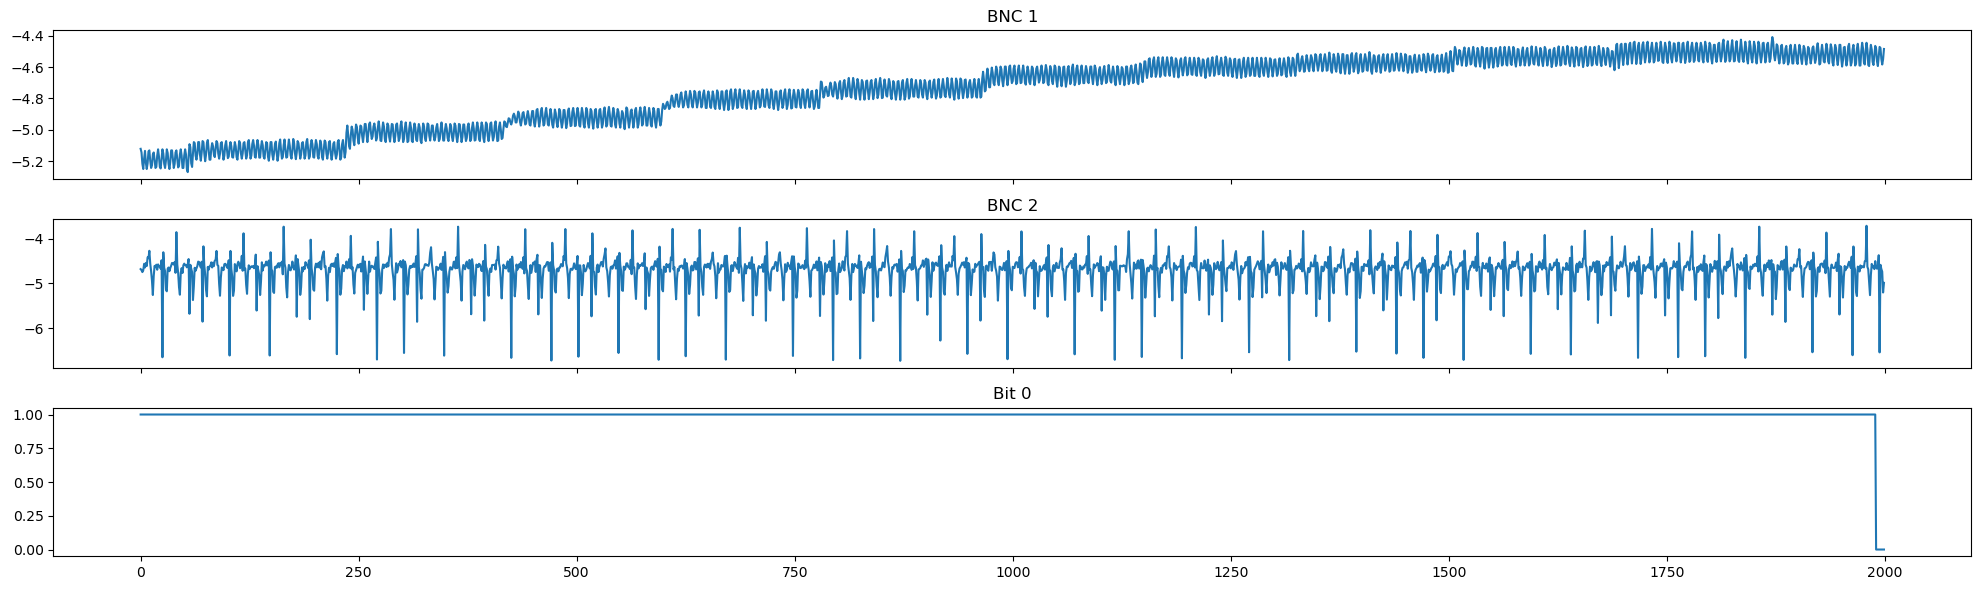

In [ ]:
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(20, 6))

df1['bnc'].plot(ax=axes[0], title='BNC 1')

df2['bnc'].plot(ax=axes[1], title='BNC 2')

df1['bit_0'].plot(ax=axes[2], title='Bit 0')
axes[1].set_xlabel('Time')

plt.tight_layout()
plt.show()